### Full Name : Parsa Hatami
### Student Number : 400100962


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(batch_size=64, train_ratio=0.8):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [3]:
def explore_data(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    for i in range(10):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
    plt.show()

    label_counts = torch.tensor([0]*10)
    for _, labels in data_loader:
        for label in labels:
            label_counts[label] += 1
    plt.figure(figsize=(8, 4))
    plt.bar(range(10), label_counts.numpy())
    plt.xlabel("Digit Label")
    plt.ylabel("Frequency")
    plt.title("Distribution of Labels")
    plt.show()


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 49292209.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 1391852.35it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 12750748.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2648481.69it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



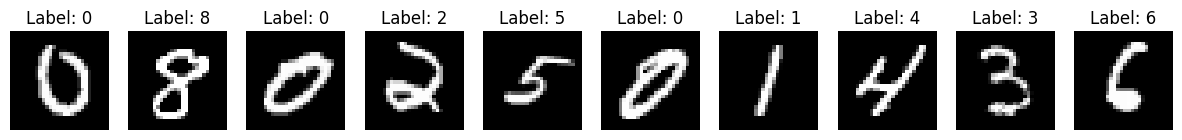

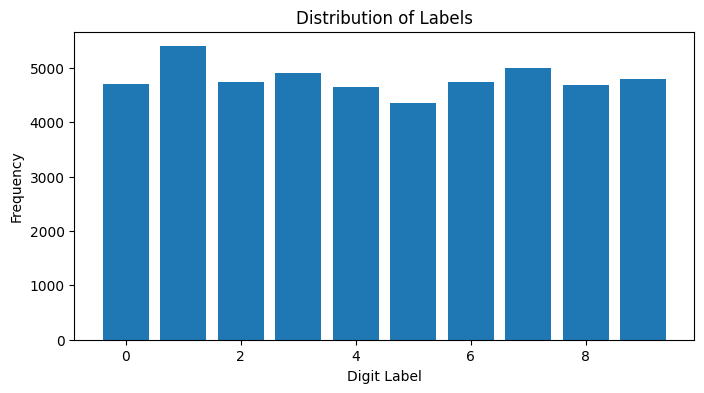

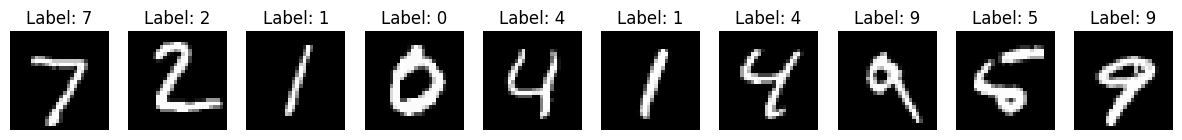

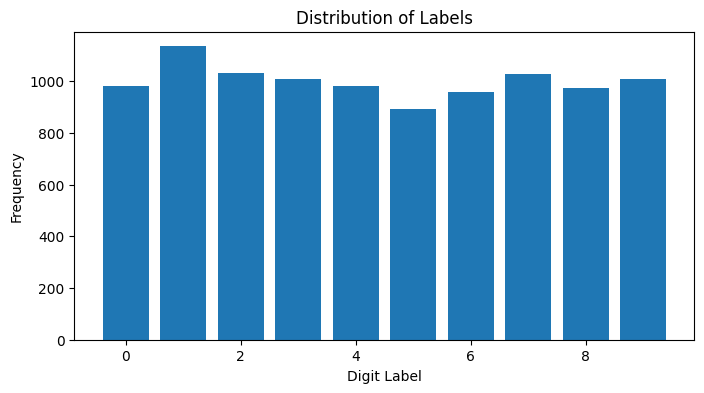

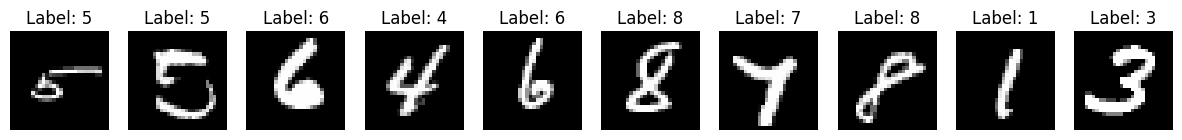

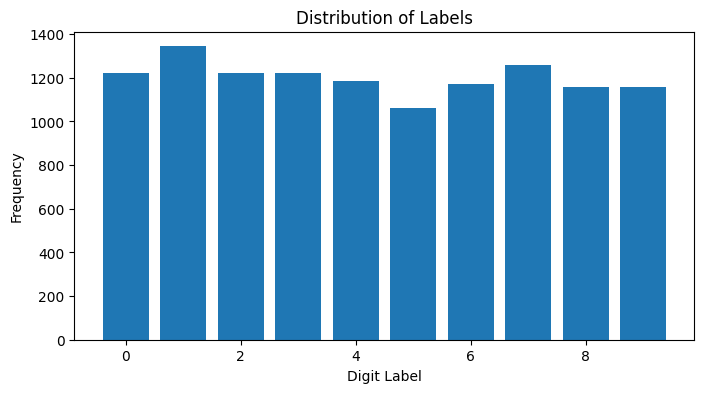

In [4]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader)
explore_data(test_loader)
explore_data(val_loader)


Prepare the data for use with the CART algorithm by flattening the images.

In [5]:
def prepare_data_for_cart(data_loader):
    flattened_data = []
    labels = []
    
    for images, label_batch in data_loader:
        flattened_images = images.view(images.size(0), -1)
        flattened_data.append(flattened_images)
        labels.append(label_batch)
    
    flattened_data = torch.cat(flattened_data)
    labels = torch.cat(labels)
    
    return flattened_data.numpy(), labels.numpy()

In [6]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

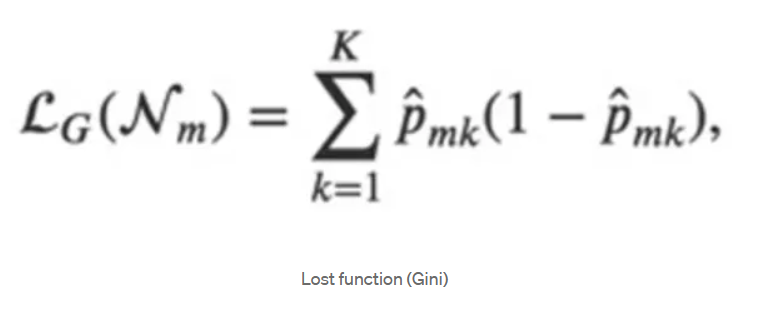

In [7]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        if depth >= self.max_depth or num_samples < self.min_samples_split or len(np.unique(y)) == 1:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feature, threshold = self._find_best_split(X, y)
        
        if feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left_indices = X[:, feature] < threshold
        right_indices = X[:, feature] >= threshold
        left = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return Node(feature=feature, threshold=threshold, left=left, right=right)

    def _find_best_split(self, X, y):
        best_gini = float("inf")
        best_feature, best_threshold = None, None
        num_samples, num_features = X.shape
        
        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold
                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue
                
                gini = self._calculate_gini_split(y[left_indices], y[right_indices])
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gini_split(self, left_y, right_y):
        left_gini = self._gini_impurity(left_y)
        right_gini = self._gini_impurity(right_y)
        n = len(left_y) + len(right_y)
        weighted_gini = (len(left_y) / n) * left_gini + (len(right_y) / n) * right_gini
        return weighted_gini

    def _gini_impurity(self, y):
        m = len(y)
        if m == 0:
            return 0
        label_counts = np.bincount(y)
        probabilities = label_counts / m
        gini = 1 - np.sum(probabilities ** 2)
        return gini

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] < node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)


## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

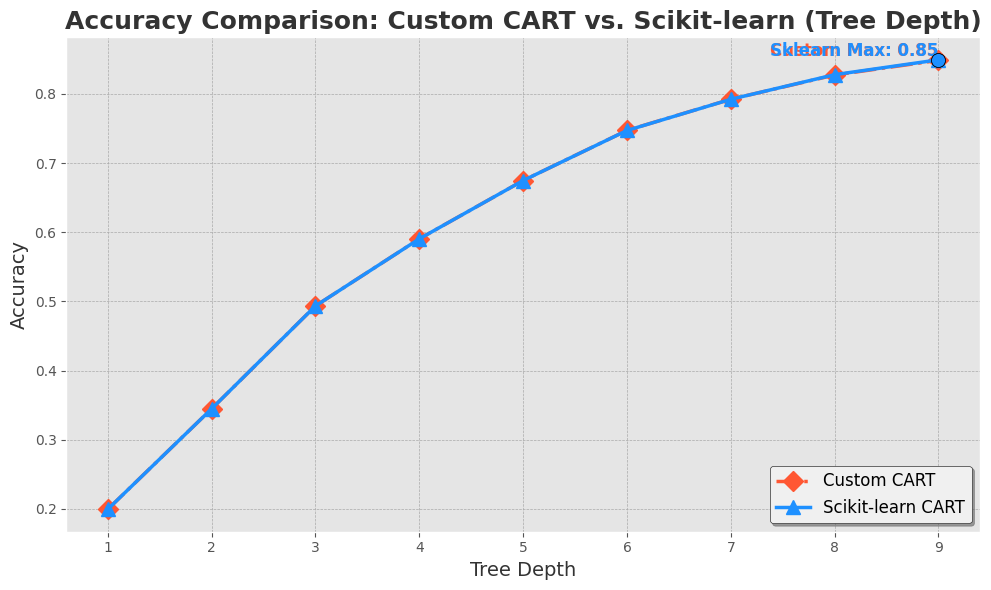

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

depths = np.arange(1, 10)
custom_accuracies = []
sklearn_accuracies = []

for depth in depths:
    custom_tree = DecisionTree_CART(max_depth=depth)
    custom_tree.fit(X_train, y_train)
    custom_predictions = custom_tree.predict(X_test)
    custom_acc = accuracy_score(y_test, custom_predictions)
    custom_accuracies.append(custom_acc)

    sklearn_tree = DecisionTreeClassifier(max_depth=depth)
    sklearn_tree.fit(X_train, y_train)
    sklearn_predictions = sklearn_tree.predict(X_test)
    sklearn_acc = accuracy_score(y_test, sklearn_predictions)
    sklearn_accuracies.append(sklearn_acc)

plt.figure(figsize=(10, 6))
plt.style.use('ggplot')

plt.plot(depths, custom_accuracies, label='Custom CART', marker='D', color='#FF5733', linestyle='-.', linewidth=2.5, markersize=10)
plt.plot(depths, sklearn_accuracies, label='Scikit-learn CART', marker='^', color='#1E90FF', linestyle='-', linewidth=2.5, markersize=10)

plt.title('Accuracy Comparison: Custom CART vs. Scikit-learn (Tree Depth)', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Tree Depth', fontsize=14, color='#333333')
plt.ylabel('Accuracy', fontsize=14, color='#333333')

plt.legend(loc='lower right', fontsize=12, frameon=True, shadow=True, facecolor='#F0F0F0', edgecolor='#333333')
plt.grid(color='#A9A9A9', linestyle='--', linewidth=0.5)

max_custom_depth = depths[np.argmax(custom_accuracies)]
max_custom_acc = max(custom_accuracies)
max_sklearn_depth = depths[np.argmax(sklearn_accuracies)]
max_sklearn_acc = max(sklearn_accuracies)
plt.scatter([max_custom_depth], [max_custom_acc], color='#FF5733', s=100, edgecolor='black', zorder=5)
plt.scatter([max_sklearn_depth], [max_sklearn_acc], color='#1E90FF', s=100, edgecolor='black', zorder=5)

plt.text(max_custom_depth, max_custom_acc, f'Custom Max: {max_custom_acc:.2f}', ha='right', va='bottom', color='#FF5733', fontsize=12, fontweight='bold')
plt.text(max_sklearn_depth, max_sklearn_acc, f'Sklearn Max: {max_sklearn_acc:.2f}', ha='right', va='bottom', color='#1E90FF', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## Question
What is the difference between ID3 and CART algorithm

### Difference Between ID3 and CART Algorithms

Both **ID3 (Iterative Dichotomiser 3)** and **CART (Classification and Regression Trees)** are popular decision tree algorithms used in machine learning, but they differ in several key aspects, including the type of trees they build, the splitting criteria they use, and their flexibility in handling different types of target variables.

#### 1. Type of Target Variable
   - **ID3**: The ID3 algorithm is designed for **classification tasks only**. It builds a tree based on categorical (discrete) target variables, meaning it cannot be used for regression.
   - **CART**: The CART algorithm supports both **classification** and **regression** tasks. It can handle continuous (numerical) target variables for regression and categorical target variables for classification.

#### 2. Splitting Criteria
   - **ID3**: The ID3 algorithm uses **Information Gain** based on **Entropy** to decide the best feature to split on at each node. Information Gain measures how much information a feature provides about the target variable.
   - **CART**: CART uses **Gini Impurity** for classification and **Mean Squared Error (MSE)** for regression as the splitting criterion. Gini Impurity measures the probability of incorrectly classifying a randomly chosen element in a dataset, while MSE calculates the average squared difference between the observed and predicted values.

#### 3. Type of Tree Structure
   - **ID3**: ID3 generates a **multi-way tree** structure, meaning that a feature with multiple categories can result in multiple branches from a single node. Each unique value of a categorical feature may create a new branch, leading to more branches at each split.
   - **CART**: CART creates a **binary tree** structure. Each internal node has only two branches (left and right), regardless of the number of unique values in the feature. This binary structure applies to both classification and regression trees.

#### 4. Pruning Methods
   - **ID3**: The original ID3 algorithm does not support pruning. It tends to build a complete tree, which can lead to overfitting, especially on noisy datasets. However, later extensions like C4.5 and C5.0 added pruning methods to reduce tree complexity.
   - **CART**: CART includes a built-in **pruning** mechanism, which can be applied to reduce the size of the tree and prevent overfitting. CART typically uses **cost-complexity pruning** to remove branches that provide little benefit to the model’s accuracy.

#### 5. Handling of Numerical and Categorical Data
   - **ID3**: ID3 was initially designed to handle categorical features only. Extensions to ID3, such as C4.5, added the ability to handle continuous data by introducing thresholds for splitting.
   - **CART**: CART can handle both **numerical and categorical** data natively. For numerical features, CART determines a threshold to split the data into two branches.

#### 6. Flexibility and Usage
   - **ID3**: Due to its focus on classification and categorical data, ID3 is primarily used in simpler, categorical classification problems.
   - **CART**: CART is more flexible, supporting both regression and classification, and can be applied to a wider range of problems. Its binary structure and pruning capabilities make it well-suited for real-world applications where overfitting and interpretability are concerns.

### Summary Table

| Aspect                    | ID3                               | CART                                   |
|---------------------------|-----------------------------------|----------------------------------------|
| Target Variable           | Classification only              | Classification and Regression          |
| Splitting Criterion       | Information Gain (Entropy)       | Gini Impurity (Classification), MSE (Regression) |
| Tree Structure            | Multi-way                        | Binary (two-way)                       |
| Pruning                   | Not supported                    | Supported (Cost-Complexity Pruning)    |
| Handling of Data Types    | Categorical (original ID3)       | Categorical and Numerical              |
| Application Flexibility   | Limited to classification        | More flexible, suitable for various tasks |

### Conclusion
The **ID3 algorithm** is primarily suited for basic classification tasks with categorical features, while the **CART algorithm** is more versatile, supporting both classification and regression tasks, along with numerical and categorical data. The binary tree structure, pruning capabilities, and flexibility make CART widely used in real-world machine learning applications, whereas ID3 is mainly of historical and educational interest.
